# Improving CIFAR-10 Classifiers Using ResNeXt
## By: Mason Nolan
---


## Introduction

Convolution neural networks have composed arguably the largest portion of our course, and a strong introduction to architectures was through the **DenseNet** paper [shared](https://arxiv.org/pdf/1608.06993). The paper outlined an efficient architecture that reduced the amount of parameters required for a ResNet model, while obtaining better results, by introducing interconnections between the layers. While revolutionary, other architectures have also sprouted that were based on the original ResNet structure. Notably, [ResNeXt](https://arxiv.org/pdf/1611.05431) was one structure that was adapted from the ResNet architecture, and has even spawned its own variants such as [SKNet](https://arxiv.org/pdf/1903.06586v2), which for a small period of time provided benchmark results in image classification.

We will examine the ResNeXt structure and build ResNeXt models from scratch, comparing the results of our models with the best performing DenseNet obtained through experimentation previously in the course. We will also discuss potential changes to our model for performance or speed, and exploring the decisions made in our final model. Our models will all be tested on the CIFAR-10 dataset, as to keep the data not overly complex and allow our models to compile relatively quickly.

## DenseNet Baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, AveragePooling2D, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import CosineDecay
import tensorflow.keras.backend as K
import gc

Earlier in our course, we built a DenseNet architecture and trained it on the CIFAR-10 dataset. The structure we used resembled the DenseNet-121 structure, which was highlighted in the original DenseNet paper. The following is the code required for the DenseNet architecture.

In [ ]:
def densenet_composition(x, k):
    # x = input
    # k = growth rate
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(4*k, (1, 1), padding='same')(x)  # Bottleneck

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(k, (3, 3), padding='same')(x)  # 3x3 convolution

    return x

def DenseNet_block(x, k, layers):
    # x and k are the same parameters for the composition function imbedded in this function
    # layers = numbers of layers in this dense block
    for i in range(layers):
      out = densenet_composition(x, k)
      x = Concatenate()([x, out]) # ensures that each output also includes the initial x input, including the feature maps from the previous layer(s)

    return x

def transition(x, compression_factor=0.5):
    # x = input
    # compression_factor = \theta, the factor determining reduction of number of feature maps to keep complexity low. 0.5 by default, per paper (and assignment) standards.
    channels = int(x.shape[-1])
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(int(compression_factor*channels), (1, 1), padding='same')(x) # 1x1 convolution layer to lower number of features

    x = AveragePooling2D(pool_size=(2, 2), strides=2, padding='same')(x) # 2x2 Avg. Pooling with stride 2.

    return x

def DenseNet(input_shape, k=32):
    inputs = layers.Input(shape=input_shape)
    x = Conv2D(2*k, (3, 3), padding='same', strides=1)(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = DenseNet_block(x, k, 6)
    x = transition(x)

    x = DenseNet_block(x, k, 12)
    x = transition(x)

    x = DenseNet_block(x, k, 24)
    x = transition(x)

    x = DenseNet_block(x, k, 16)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

To achieve our best results, we augmented the CIFAR-10 training data to make our model more robust and prevent overfitting.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Load CIFAR-10 data

x_train = x_train / 255.0 # Normalizing the x values assists with NN training
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10) # One-hot encoding the integer labelled target data.
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The data was then augmented to improve performance.

In [ ]:
datagen = ImageDataGenerator( # A transformer to randomly apply several transformations to an input.
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
datagen.fit(x_train)

Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 301s 200ms/step - accuracy: 0.3582 - loss: 1.7659 - val_accuracy: 0.4894 - val_loss: 1.4548 - learning_rate: 2.0000e-04
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.5241 - loss: 1.3298 - val_accuracy: 0.5659 - val_loss: 1.2297 - learning_rate: 2.0000e-04
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.6053 - loss: 1.1170 - val_accuracy: 0.5307 - val_loss: 1.4933 - learning_rate: 2.0000e-04
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.6503 - loss: 0.9875 - val_accuracy: 0.6110 - val_loss: 1.1708 - learning_rate: 2.0000e-04
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.6899 - loss: 0.8814 - val_accuracy: 0.7096 - val_loss: 0.8659 - learning_rate: 2.0000e-04
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.7157 - loss: 0.8070 - val_accuracy: 0.7162 - val_loss: 0.8501 - learning_rate: 2.0000e-04
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accur

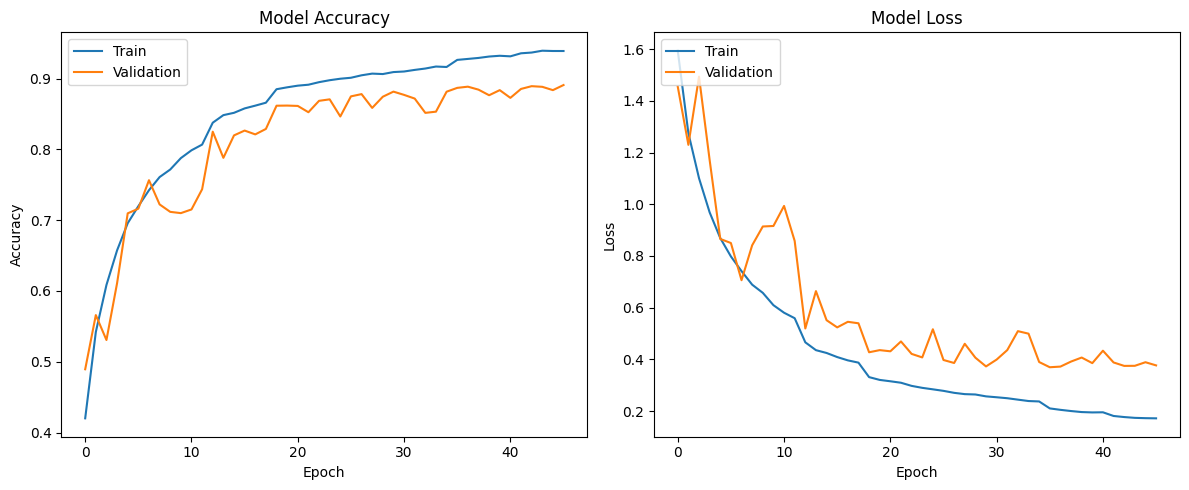

In [ ]:
densemodel = DenseNet(input_shape=(32, 32, 3), k=32)

densemodel.compile(optimizer=Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"]) # Small initial learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop if validation loss begins to increase
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6) # Shrink learning rate when loss function plateaus
history = densemodel.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_test, y_test), epochs=75, callbacks=[early_stopping, lr_scheduler])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = densemodel.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

y_pred = densemodel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report precision, recall, F1 score, and per-class accuracy
report = classification_report(y_true, y_pred_classes)
print(report)

313/313 - 5s - 15ms/step - accuracy: 0.8868 - loss: 0.3698
Test accuracy: 0.8867999911308289
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1000
           1       0.94      0.95      0.95      1000
           2       0.87      0.84      0.86      1000
           3       0.81      0.76      0.78      1000
           4       0.84      0.90      0.87      1000
           5       0.88      0.80      0.84      1000
           6       0.87      0.95      0.91      1000
           7       0.92      0.91      0.91      1000
           8       0.96      0.92      0.94      1000
           9       0.88      0.95      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
densemodel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      8,320 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,896 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,416 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ concatenate[0][0

 Total params: 7,045,962 (26.88 MB)

 Trainable params: 6,964,490 (26.57 MB)

 Non-trainable params: 81,472 (318.25 KB)

The DenseNet model achieves an accuracy of $89\%$ (and we have historically reached $90\%$ with this model) and uses 7M parameters. Our goal in this project will be to best this accuracy, but we will make note of the number of parameters, which are vital for determining practicality of our model and reducing computation time.

## ResNet vs ResNeXt vs DenseNet

ResNeXt developed from ResNet by looking to partition the main convolution layer in the ResNet block into smaller groups and evaluating each in parallel, then summing the result. Parallelizing this operation improves performance with GPUs, and was found to be an effective way to improve the models accuracy without making the model deeper or making the blocks wider. In the grand scheme of things, ResNeXt tries to split the most cumbersome convolution task into several easier tasks and then combine the results of each task, while ResNet prefers to keep the original larger task intact. The degree of how many partitions the layer is split into is called the "cardinality" of the block.

On the other hand, DenseNet operates by receiving inputs from previous layers into each layer's results, concatenating results rather than summing them. The layers tend to be narrow, and the overall architecture can grow quite wide of the network is made to be deep, but the efficiency of the architecture means that making the model deep is often unnecessary, so the models tend to have a low number of parameters.

ResNeXt requires more complex models than DenseNet structures, since it does not utilize its parameters as efficiently as DenseNet. Although DenseNet allows our model to learn from previous layers, ResNeXt's parallel structure allows several small-scale patterns to be identified in the data and tends to lead to higher accuracy overall. Additionally, ResNeXt utilizes GPU parallelization extremely well, so training time tends to be much faster than DenseNet.

With this all in mind, we can now begin to test ResNeXt models.

## Initial ResNeXt Model

Let us define the integral ResNeXt block, followed by a basic structure.

In [ ]:
def resnext_block(x, n, cardinality=16, stride=1):
    # x = input
    # n = filters
    # cardinality = # of groups
    # stride = stride length for grouped convolution layer
    shortcut = x

    x = Conv2D(n, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(n, (3, 3), strides=stride, groups=cardinality, padding='same')(x)  # 3x3 convolution with larger stride and grouped into (16) parts
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(n, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x) # Note: no ReLu here, save that until the end.

    if stride != 1 or shortcut.shape[-1] != n: # Make the shortcut match the dimensions of x if they are not compatible
        shortcut = Conv2D(n, 1, strides=stride, groups=cardinality, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = ReLU()(x)

    return x

def ResNeXt(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', strides=1)(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

    x = resnext_block(x, 128)
    x = resnext_block(x, 128)
    x = resnext_block(x, 256, stride=2)
    x = resnext_block(x, 256)
    x = resnext_block(x, 512, stride=2)
    x = resnext_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [ ]:
resnextmodel = ResNeXt((32, 32, 3))
resnextmodel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    147,584 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     16,512 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        640 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     16,512 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_5[0][0]  

 Total params: 7,446,410 (28.41 MB)

 Trainable params: 7,433,866 (28.36 MB)

 Non-trainable params: 12,544 (49.00 KB)

The model we have constructed is deeper and wider than our DenseNet baseline model, yet it contains 7.4M parameters compared to the DenseNet's 7.0M parameters. More typical ResNeXt models often contain far more ResNeXt blocks than our prototype model, so it is not necessarily typical that the models have comparable numbers of parameters for the same task. Fortunately, the CIFAR-10 dataset is somewhat of a "small" task, so the models not need be too convoluted.

Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 80ms/step - accuracy: 0.2939 - loss: 2.1666 - val_accuracy: 0.5022 - val_loss: 1.4426 - learning_rate: 2.0000e-04
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.4747 - loss: 1.4795 - val_accuracy: 0.5574 - val_loss: 1.2724 - learning_rate: 2.0000e-04
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5460 - loss: 1.2809 - val_accuracy: 0.5713 - val_loss: 1.2169 - learning_rate: 2.0000e-04
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5924 - loss: 1.1545 - val_accuracy: 0.6135 - val_loss: 1.2040 - learning_rate: 2.0000e-04
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.6336 - loss: 1.0434 - val_accuracy: 0.5750 - val_loss: 1.4645 - learning_rate: 2.0000e-04
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.6651 - loss: 0.9596 - val_accuracy: 0.6551 - val_loss: 1.0538 - learning_rate: 2.0000e-04
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accurac

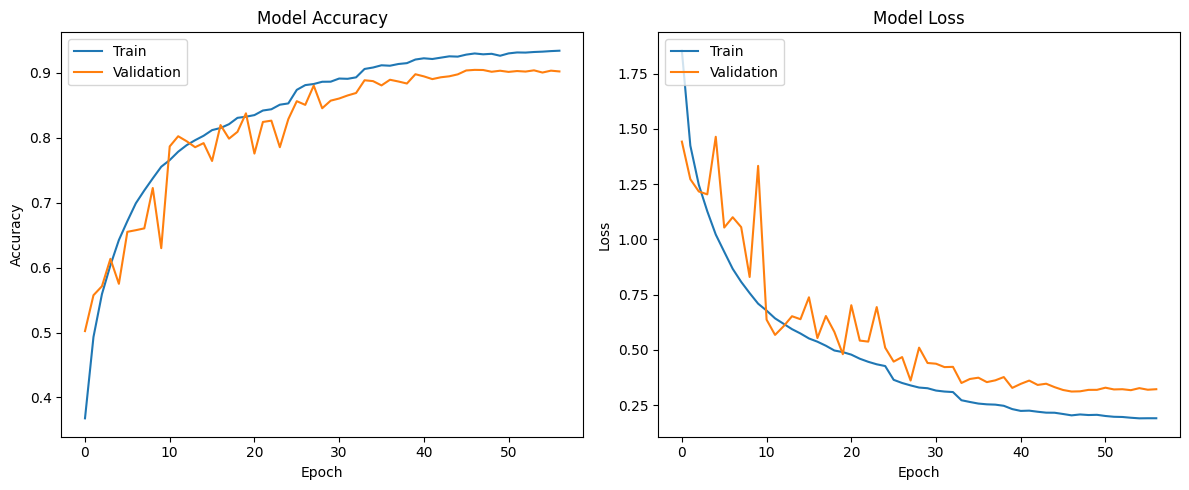

In [ ]:
resnextmodel.compile(optimizer=Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"]) # Small initial learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop if validation loss begins to increase
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6) # Shrink learning rate when loss function plateaus
history = resnextmodel.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_test, y_test), epochs=75, callbacks=[early_stopping, lr_scheduler])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = resnextmodel.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

y_pred = resnextmodel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report precision, recall, F1 score, and per-class accuracy
report = classification_report(y_true, y_pred_classes)
print(report)

313/313 - 2s - 8ms/step - accuracy: 0.9045 - loss: 0.3117
Test accuracy: 0.9045000076293945
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1000
           1       0.93      0.97      0.95      1000
           2       0.90      0.86      0.88      1000
           3       0.83      0.80      0.81      1000
           4       0.91      0.89      0.90      1000
           5       0.90      0.83      0.87      1000
           6       0.90      0.95      0.92      1000
           7       0.92      0.93      0.92      1000
           8       0.96      0.93      0.94      1000
           9       0.89      0.95      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Our simple ResNeXt model performed with an accuracy of 90.5% accuracy on the very first attempt with almost no tuning and comparable number of parameters. The model also compiled faster than the DenseNet model. This does showcase an improvement in accuracy, but not a marked one. The results produced were consistent, with the ResNeXt model almost always edging out the DenseNet model.

A noteworthy deviation we took from the ResNeXt's papers recommendation for training was that we used the Adam optimizer. The Adam optimizer is very reliable and flexible with choice of initial learning rate, so this was done out of convenience. The recommended optimizer was basic momentum gradient descent, which was found to have better results and faster convergence. Since our model does not match the paper's demonstrated architecture (ResNeXt-50), we had to adjust the parameters of the optimizer to maintain consistent results.

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - accuracy: 0.2491 - loss: 2.6047 - val_accuracy: 0.4204 - val_loss: 1.5795 - learning_rate: 0.1000
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4357 - loss: 1.5529 - val_accuracy: 0.2490 - val_loss: 3.0681 - learning_rate: 0.1000
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5092 - loss: 1.3597 - val_accuracy: 0.5259 - val_loss: 1.3628 - learning_rate: 0.1000
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5638 - loss: 1.2286 - val_accuracy: 0.5262 - val_loss: 1.4854 - learning_rate: 0.1000
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6068 - loss: 1.1122 - val_accuracy: 0.6608 - val_loss: 0.9844 - learning_rate: 0.1000
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6376 - loss: 1.0305 - val_accuracy: 0.6172 - val_loss: 1.1038 - learning_rate: 0.1000
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6602 - l

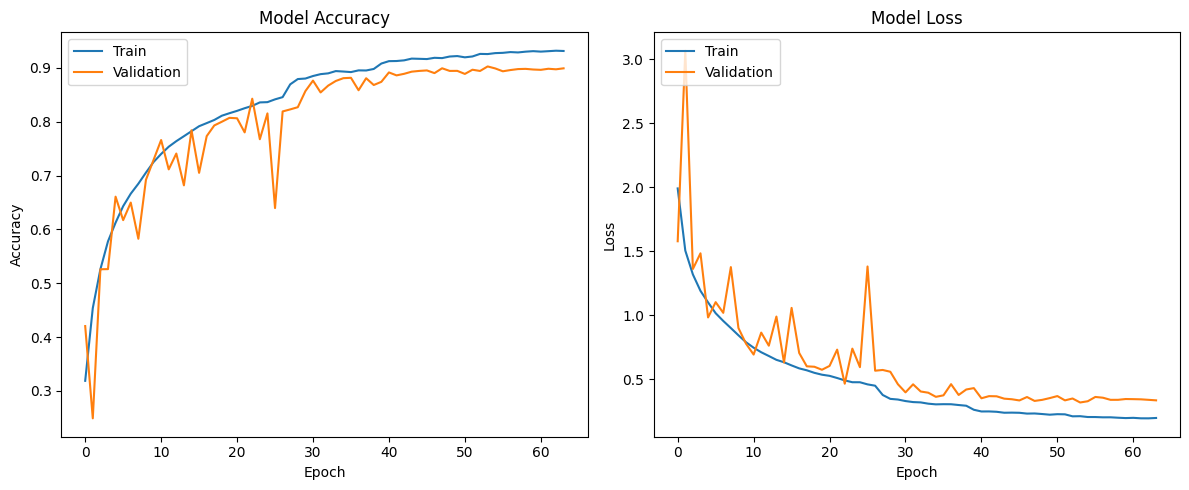

In [ ]:
resnextmodel = ResNeXt((32, 32, 3))

resnextmodel.compile(optimizer=SGD(learning_rate=0.1, momentum=0.85, weight_decay=0.000025), loss="categorical_crossentropy", metrics=["accuracy"]) # SGD instead of Adam, using slightly altered parameters compared the paper.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop if validation loss begins to increase
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.333, patience=4, min_lr=1e-5) # Shrink learning rate when loss function plateaus (less strict parameters than paper)
history = resnextmodel.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_test, y_test), epochs=75, callbacks=[early_stopping, lr_scheduler]) # Larger batch size since the paper used 256, but we use 128 since the dataset is simple/smaller than ImageNet

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = resnextmodel.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

y_pred = resnextmodel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report precision, recall, F1 score, and per-class accuracy
report = classification_report(y_true, y_pred_classes)
print(report)

313/313 - 1s - 4ms/step - accuracy: 0.9027 - loss: 0.3200
Test accuracy: 0.9027000069618225
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.93      0.97      0.95      1000
           2       0.89      0.88      0.88      1000
           3       0.83      0.78      0.80      1000
           4       0.90      0.89      0.90      1000
           5       0.88      0.82      0.85      1000
           6       0.90      0.95      0.93      1000
           7       0.90      0.94      0.92      1000
           8       0.96      0.94      0.95      1000
           9       0.90      0.95      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Using the more basic optimizer, we still manage to obtain results greater than 90%, still edging out DenseNet. We did not beat the model's performance using the Adam optimizer, though it is suspected this could be fixed with more fine tuning of the SGD parameters, though we did not find settings that were superior, only approximately equal at best.

## Deep ResNeXt Model

We are willing to showcase a deeper ResNeXt model.

In [ ]:
def resnext_block_reg(x, n, cardinality=16, stride=1): # This is a repeat of the previous resnext_block, but it introduces regularizers on the convolution layers and removes bias terms.
    # x = input
    # n = filters
    # cardinality = # of groups
    # stride = stride length for grouped convolution layer
    shortcut = x

    x = Conv2D(n, (1, 1), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(x) # Introduce regularizers in all Conv2D layers and do not use bias terms
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(n, (3, 3), strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(x)  # 3x3 convolution with larger stride
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(n, 1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(x)
    x = BatchNormalization()(x) # Note: no ReLu here, save that until the end.

    if stride != 1 or shortcut.shape[-1] != n: # Make the shortcut match the dimensions of x if they are not compatible
        shortcut = Conv2D(n, 1, strides=stride, groups=cardinality, padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = ReLU()(x)

    return x

def ResNeXt_deep(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', strides=1, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x) # Global pooling layer replaced with BN and ReLU, after global pooling was found to lower performance.
    x = layers.ReLU()(x)

    x = resnext_block_reg(x, 128)
    x = resnext_block_reg(x, 128)
    x = resnext_block_reg(x, 128)
    x = resnext_block_reg(x, 256, stride=2)
    x = resnext_block_reg(x, 256, stride=2)
    x = resnext_block_reg(x, 256, stride=2)
    x = resnext_block_reg(x, 512, stride=2)
    x = resnext_block_reg(x, 512, stride=2)
    x = resnext_block_reg(x, 512, stride=2)


    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x) # Relax the Dropout ratio for our more complex model, since regularization is already being used. In this case, we drop it all together.
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [ ]:
resnextdeepmodel = ResNeXt_deep((32, 32, 3))
resnextdeepmodel.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32,    │      1,728 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │      8,192 │ re_lu_56[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32,    │    147,456 │ re_lu_57[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     16,384 │ re_lu_58[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │        512 │ re_lu_56[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_59 (ReLU)     │ (None, 32, 32,    │          0 │ add_18[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     16,384 │ re_lu_59[0][0]  

 Total params: 11,282,890 (43.04 MB)

 Trainable params: 11,261,770 (42.96 MB)

 Non-trainable params: 21,120 (82.50 KB)

Our deeper model contains 9 ResNeXt blocks with 11M paramters. It should be noted that the ResNeXt-50 model in the paper contained 16 ResNeXt blocks and had 25M parameters, though this model was primarily suited for the ImageNet dataset and warrants the more complex structure.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Load CIFAR-10 data

x_train = x_train / 255.0 # Normalizing the x values assists with NN training
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10) # One-hot encoding the integer labelled target data.
y_test = to_categorical(y_test, 10)

datagen = ImageDataGenerator( # Milder augmentation for deeper model
    width_shift_range=0.12,
    height_shift_range=0.12,
    horizontal_flip=True,
    fill_mode='reflect'
)
datagen.fit(x_train)

The original SGD optimizer contained a learning rate schedule, where the learning rate was divided by 10 every 30 epochs (3 times). During testing, it was found that the model stagnated for many epochs before sharply adjusting after the learning rate changed. To prevent overfitting from occuring before discrete learning rate changes, we opted to use a different learning rate schedule: CosineDecay. This scheduler smoothly transitions the learning rate over every epoch so that we do not experience these sharp changes that interfered with our performance.

In [ ]:
steps_per_epoch = x_train.shape[0] // 256
lr_schedule = CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=steps_per_epoch * 75,
    alpha=0.001  # final LR will be 0.001 * initial LR
)

Epoch 1/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 78s 243ms/step - accuracy: 0.2878 - loss: 3.8204 - val_accuracy: 0.3412 - val_loss: 3.7216
Epoch 2/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.4650 - loss: 3.2651 - val_accuracy: 0.4818 - val_loss: 3.1322
Epoch 3/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.5282 - loss: 2.9663 - val_accuracy: 0.5663 - val_loss: 2.8245
Epoch 4/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.5794 - loss: 2.7275 - val_accuracy: 0.5688 - val_loss: 2.6783
Epoch 5/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.6201 - loss: 2.5176 - val_accuracy: 0.6338 - val_loss: 2.4296
Epoch 6/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.6482 - loss: 2.3484 - val_accuracy: 0.5839 - val_loss: 2.5334
Epoch 7/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.6741 - loss: 2.1989 - val_accuracy: 0.6805 - val_loss: 2.1498
Epoch 8/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.7039 - loss: 2

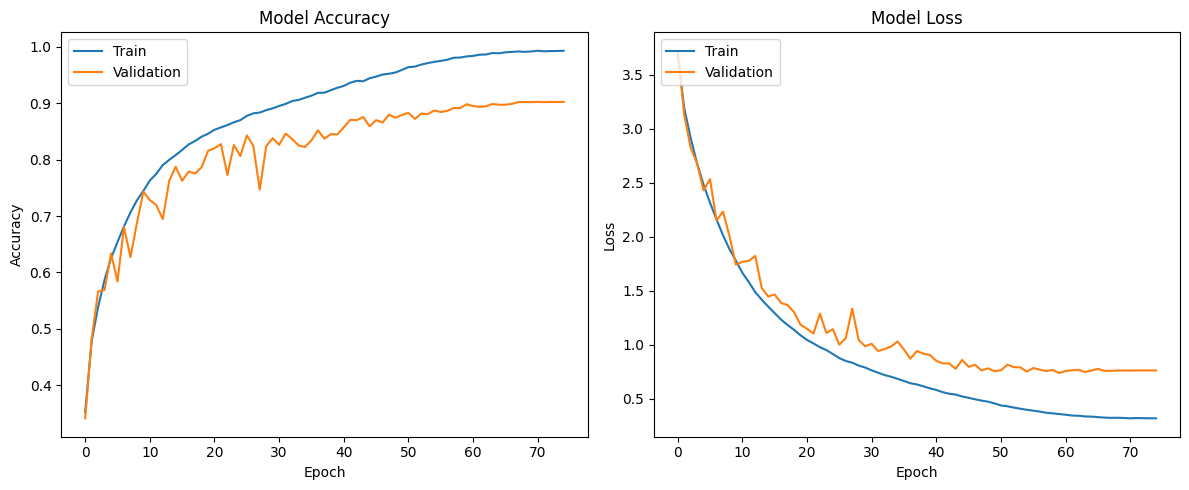

In [ ]:
resnextdeepmodel.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
history = resnextdeepmodel.fit(datagen.flow(x_train, y_train, batch_size=256), validation_data=(x_test, y_test), epochs=75)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = resnextdeepmodel.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

y_pred = resnextdeepmodel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report precision, recall, F1 score, and per-class accuracy
report = classification_report(y_true, y_pred_classes)
print(report)

313/313 - 2s - 5ms/step - accuracy: 0.9023 - loss: 0.7633
Test accuracy: 0.9023000001907349
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1000
           1       0.94      0.97      0.95      1000
           2       0.87      0.88      0.87      1000
           3       0.80      0.81      0.81      1000
           4       0.90      0.88      0.89      1000
           5       0.88      0.83      0.85      1000
           6       0.89      0.95      0.92      1000
           7       0.95      0.92      0.94      1000
           8       0.95      0.93      0.94      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Final Remarks

Our deeper model that kept the optimizer and structure more true to the ResNeXt 16x64d structure performed similarly to our initial model. Notably, the model loss and model accuracy graphs do show more consistent results however, where erratic behaviour is stifled much earlier. This does suggest that our architecture is more reliable in its results without significantly increasing the number of parameters compared to our base model.

ResNeXt-50 based architecture was also implemented, as well as various adjustments to data augmentation, inclusion or exclusion of Dropout, global pooling, stride amounts, cardinality, and optimization parameter adjustments, though no model was found to produce better results than $90.5\%$ consistently in this project. While this is still better than our benchmark DenseNet results, there is room to explore ResNeXt structures.

As cited before, SKNet is an example of a structure that expanded on ResNeXt to improve performance. It should also be stressed that the optimized models published for both ResNeXt and SKNet contain up to 4x the parameters of our DenseNet-121 baseline model. DenseNet *does* utilize the parameters of the model better, even if the overall accuracy is slightly inferior to the parallelized models. We can conclude that DenseNet is a better model when storage/memory is a concern, but the results from ResNeXt and the faster training times show us that if overall performance is our only concern and processing power is no limitation, then ResNeXt is superior for image classification tasks.